In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
import pandas_ta as ta
import numpy as np

In [2]:
# load data
data = pd.read_csv("./data/ETH-USD-1d.csv")

# data preprocessing

data['RSI'] = ta.rsi(data.Close, length=15)
data['EMAF'] = ta.ema(data.Close, length=10)
data['EMAM'] = ta.ema(data['Close'], length=30)
# data['EMAS'] = ta.ema(data['Close'], length=50)
data.ta.bbands(close='Close', length=10, std=2, append=True)
pd.set_option("display.max_columns", None)

data['Target'] = data['Adj Close'] - data['Open']
data['Target'] = data['Target'].shift(-1)
data['TargetNextClose'] = data['Adj Close'].shift(-1)

data.dropna(inplace=True)
data.reset_index(inplace=True)
data.drop(['Date', 'Volume'], axis=1, inplace=True)
# data.drop(['Volume', 'Close', 'Date'], axis=1, inplace=True)
dataset = data.iloc[:, 0:len(data.columns)]

In [3]:
# data scaling 
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range=(0,1))
dataset = sc.fit_transform(dataset)

dataset = pd.DataFrame(dataset)

In [4]:
dataset

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.000000,0.082619,0.082619,0.082314,0.069021,0.069453,0.986706,0.064294,0.055468,0.048864,0.061297,0.072976,0.409912,0.944459,0.622651,0.080792
1,0.000649,0.080792,0.080792,0.083192,0.081598,0.082821,0.925951,0.067682,0.057280,0.048714,0.064207,0.078546,0.462772,0.805186,0.632719,0.081861
2,0.001297,0.081861,0.081861,0.080597,0.079560,0.080768,0.932542,0.070656,0.059051,0.050432,0.067282,0.082733,0.475972,0.757168,0.635085,0.083770
3,0.001946,0.083770,0.083770,0.084900,0.083201,0.081944,0.944097,0.073452,0.060846,0.053461,0.070522,0.086042,0.464624,0.735006,0.623868,0.082194
4,0.002594,0.082194,0.082194,0.082627,0.082740,0.083846,0.889706,0.075441,0.062412,0.057082,0.073266,0.087889,0.435198,0.675027,0.597844,0.072595
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1538,0.997406,0.667364,0.667364,0.661168,0.642976,0.642623,0.595445,0.638821,0.679044,0.558179,0.624323,0.663517,0.239281,0.767699,0.518102,0.633104
1539,0.998054,0.633104,0.633104,0.662866,0.644534,0.667789,0.502292,0.642535,0.680375,0.573966,0.632846,0.665152,0.216741,0.600932,0.526700,0.601355
1540,0.998703,0.601355,0.601355,0.632934,0.605340,0.633361,0.428511,0.639550,0.679336,0.581287,0.635808,0.664061,0.204021,0.444269,0.622226,0.599236
1541,0.999351,0.599236,0.599236,0.602272,0.601342,0.601615,0.423799,0.636705,0.678211,0.600006,0.640943,0.656719,0.165864,0.391455,0.606326,0.592066


In [5]:
# feature engineering
backcandles = 10
X = []
for j in range(len(dataset.columns)):
    X.append([])
    for i in range(backcandles, len(dataset)):
        X[j].append(dataset.iloc[i - backcandles:i, j].values)

X = np.moveaxis(X, [0], [2])
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(dataset.iloc[backcandles:, -1].values, dtype=torch.float32).reshape(-1, 1)

In [6]:
# split
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [7]:
# LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [8]:
# parameters
input_size = X.shape[2]
hidden_size = 150
num_layers = 1
num_epochs = 70
batch_size = 15
learning_rate = 0.0005

In [9]:
model = LSTMModel(input_size, hidden_size, num_layers)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

In [10]:
# train
for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/70], Loss: 0.0035
Epoch [20/70], Loss: 0.0003
Epoch [30/70], Loss: 0.0002
Epoch [40/70], Loss: 0.0003
Epoch [50/70], Loss: 0.0002
Epoch [60/70], Loss: 0.0002
Epoch [70/70], Loss: 0.0002


In [11]:
# eval
model.eval()
with torch.no_grad():
    y_pred = model(X_test)


In [12]:
dataset.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.000000,0.082619,0.082619,0.082314,0.069021,0.069453,0.986706,0.064294,0.055468,0.048864,0.061297,0.072976,0.409912,0.944459,0.622651,0.080792
1,0.000649,0.080792,0.080792,0.083192,0.081598,0.082821,0.925951,0.067682,0.057280,0.048714,0.064207,0.078546,0.462772,0.805186,0.632719,0.081861
2,0.001297,0.081861,0.081861,0.080597,0.079560,0.080768,0.932542,0.070656,0.059051,0.050432,0.067282,0.082733,0.475972,0.757168,0.635085,0.083770
3,0.001946,0.083770,0.083770,0.084900,0.083201,0.081944,0.944097,0.073452,0.060846,0.053461,0.070522,0.086042,0.464624,0.735006,0.623868,0.082194
4,0.002594,0.082194,0.082194,0.082627,0.082740,0.083846,0.889706,0.075441,0.062412,0.057082,0.073266,0.087889,0.435198,0.675027,0.597844,0.072595


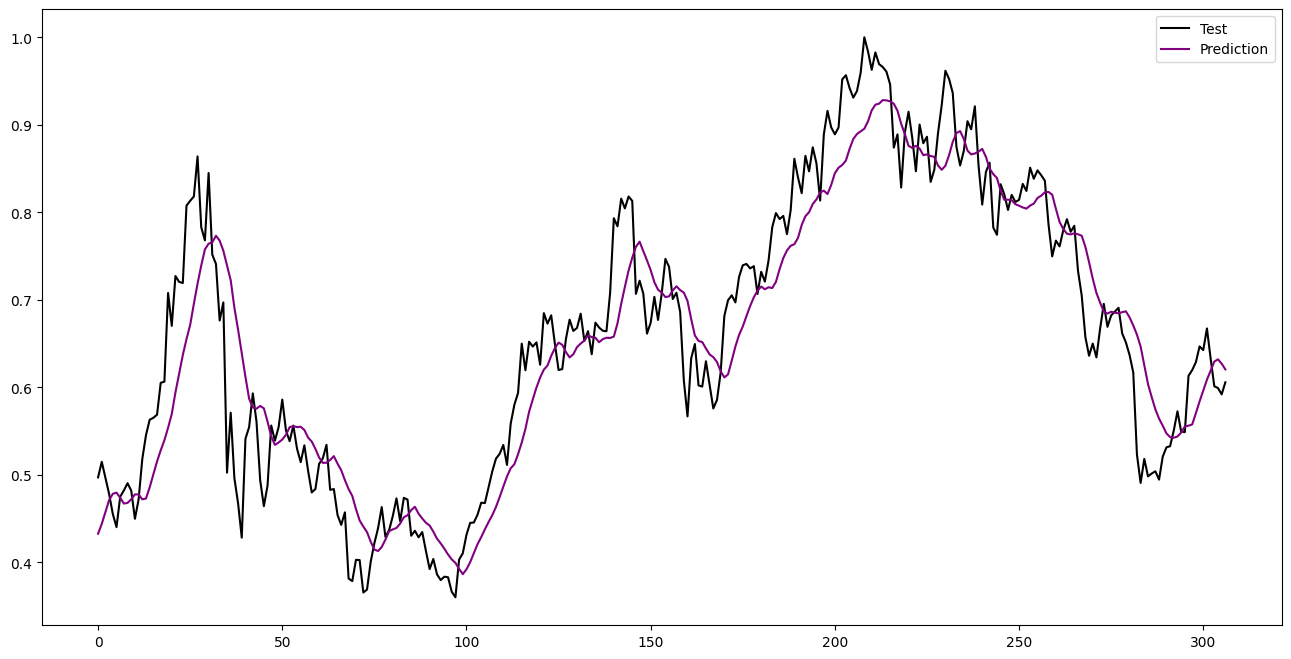

In [13]:
# plot
plt.figure(figsize=(16, 8))
plt.plot(y_test.numpy(), color='black', label='Test')
plt.plot(y_pred.numpy(), color='purple', label='Prediction')
plt.legend()
plt.show()

In [14]:
torch.save(model, 'lstm.pth')